In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import string
from sklearn.model_selection import train_test_split


In [2]:
csv_file_path = './airbnb_dataset/data.csv'
df = pd.read_csv(csv_file_path)
pd.set_option('display.max_columns', None)
df.head()

,log_price,accommodates,bathrooms,host_response_rate,bedrooms,beds,cleaning_fee_True,host_has_profile_pic_t,property_type_encoded,room_type_encoded,bed_type_encoded,cancellation_policy_encoded,city_encoded,des_sentiment_analysis,name_sentiment_analysis
0,5.010635,-0.072621,-0.404046,0.296013,-0.312048,-0.566461,1,1,-0.221989,0.879947,0.206922,1.031946,-0.417068,0.216242,-0.435248
1,5.129899,1.783653,-0.404046,0.296013,2.034955,1.027816,1,1,-0.248121,0.883912,0.178912,1.034251,-0.425829,0.837002,-1.788095
2,4.976734,0.855516,-0.404046,0.296013,-0.312048,1.027816,1,1,-0.252342,0.869698,0.126796,-0.607644,-0.445747,0.808508,-0.133695
3,6.620073,0.391448,-0.404046,0.296013,0.861454,0.230678,1,1,0.187295,0.883912,0.178912,-0.976832,2.696289,0.213627,-0.926212
4,4.744932,-0.536689,-0.404046,0.296013,-1.485549,-0.566461,1,1,-0.242856,0.875005,0.145414,-0.634193,1.380088,-0.101872,-0.095776


In [3]:
features = [col for col in df.columns if col != 'log_price' and df[col].dtype in ['int64', 'float64']]
X = df[features]
y = df['log_price']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

## 2nd Polynomial Regression

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.pipeline import make_pipeline
import plotly.graph_objects as go
import plotly.express as px


In [5]:
degree=2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

poly_val_mse = mean_squared_error(y_val, y_val_pred)
poly_val_rmse = np.sqrt(poly_val_mse)
poly_val_mae = mean_absolute_error(y_val, y_val_pred)
poly_val_r2=r2_score(y_val, y_val_pred)
# Calculating metrics for the test dataset
poly_test_mse = mean_squared_error(y_test, y_test_pred)
poly_test_rmse = np.sqrt(poly_test_mse)
poly_test_mae = mean_absolute_error(y_test, y_test_pred)
poly_test_r2 = r2_score(y_test, y_test_pred)

print("Validation Set Metrics:")
print(f"MAE: {poly_val_mae}")
print(f"RMSE: {poly_val_rmse}")
print(f"MSE: {poly_val_mse}")
print(f"R2 Score: {poly_val_r2}")


print("\nTest Set Metrics:")
print(f"MAE: {poly_test_mae}")
print(f"RMSE: {poly_test_rmse}")
print(f"MSE: {poly_test_mse}")
print(f"R2 Score: {poly_test_r2}")

Validation Set Metrics:
MAE: 0.3273651804038999
RMSE: 0.4359989717151765
MSE: 0.19009510333669127
R2 Score: 0.6258037603278721

Test Set Metrics:
MAE: 0.33016749129281514
RMSE: 0.44158629416790307
MSE: 0.19499845519694184
R2 Score: 0.6287923197704466


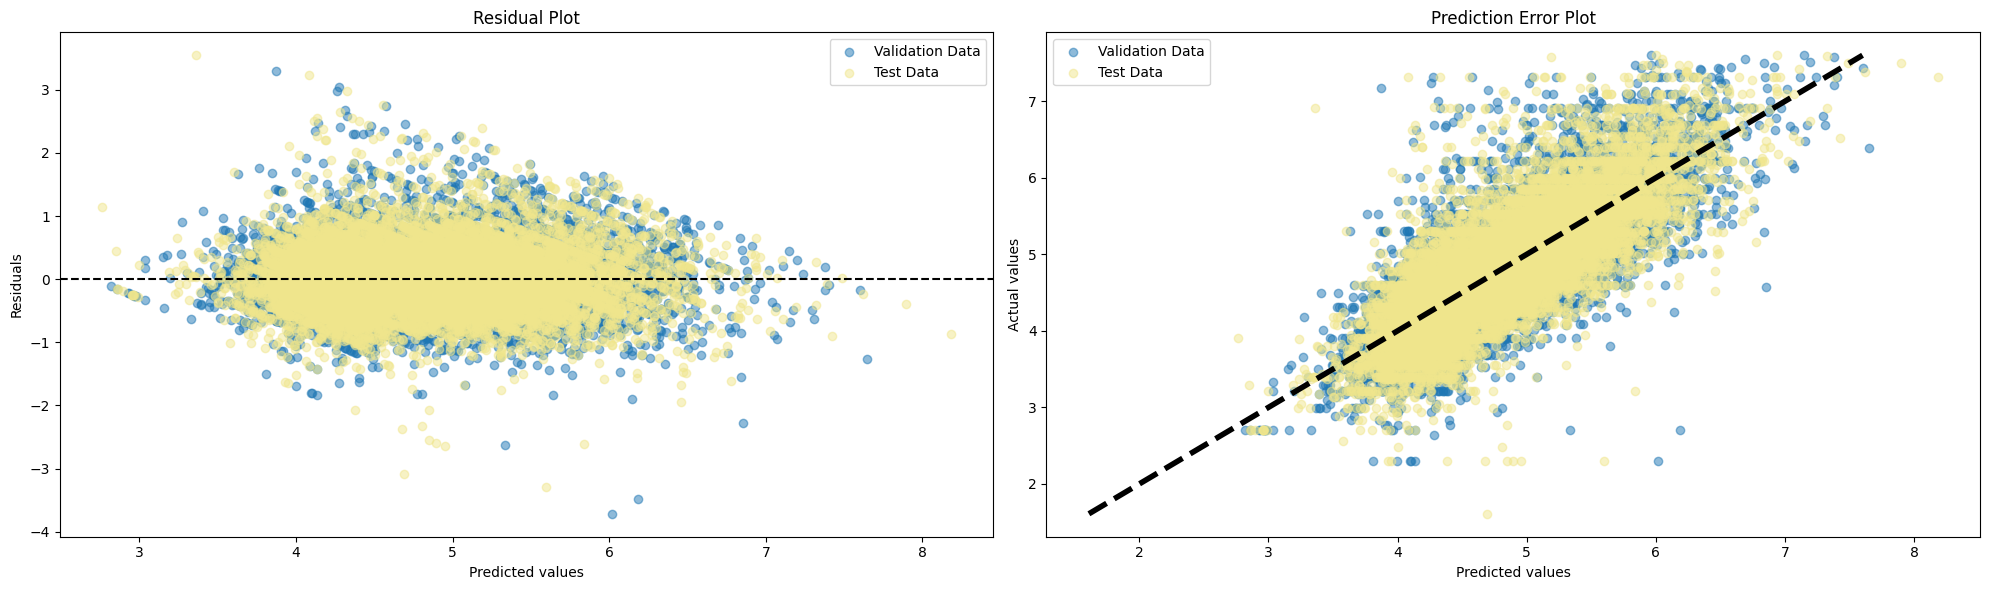

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Residual plot on the first axis
residuals_val = y_val - y_val_pred
residuals_test = y_test - y_test_pred

ax1.scatter(y_val_pred, residuals_val, alpha=0.5, label='Validation Data')
ax1.scatter(y_test_pred, residuals_test, alpha=0.5, color='Khaki', label='Test Data')
ax1.set_title('Residual Plot')
ax1.set_xlabel('Predicted values')
ax1.set_ylabel('Residuals')
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='--')

# Prediction error plot on the second axis
ax2.scatter(y_val_pred, y_val, alpha=0.5, label='Validation Data')
ax2.scatter(y_test_pred, y_test, alpha=0.5, color='Khaki', label='Test Data')
ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax2.set_title('Prediction Error Plot')
ax2.set_xlabel('Predicted values')
ax2.set_ylabel('Actual values')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

## Neual Network

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner
import keras
import tensorflow as tf

nn_model = Sequential([
    Dense(32, activation='relu', input_dim=X_train.shape[1]),
    Dense(16, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
history_nn = nn_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val),verbose=0)
mse_nn = nn_model.evaluate(X_test, y_test)
print(f"Mean Squared Error on Test Set: {mse_nn}")

463/463 [==============================] - 0s 250us/step - loss: 0.1957
Mean Squared Error on Test Set: 0.19567683339118958


### Hyperparameter Tuning

In [9]:
def build_hp_model(hp):
    model = Sequential()
    # Iterate over the number of layers
    for i in range(hp.Int('num_layers', 2, 6)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=16, max_value=96, step=16),
                        activation=hp.Choice('activation_' + str(i), ['leaky_relu'])))
    
    model.add(Dense(1))  # Output layer for regression
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

In [10]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    mode='min',
    restore_best_weights=True,
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only= False,
    mode='min'
)
tuner = keras_tuner.RandomSearch(
    hypermodel=build_hp_model,
    objective='val_loss',
    max_trials=8,
    seed=10,
    executions_per_trial=3,
    directory='tuner_results',
    project_name='keras_tuner_demo',
    overwrite=True
)

In [11]:
tuner_search = tuner.search(X_train, y_train, epochs=20, callbacks=[early_stopping, model_checkpoint], validation_data=(X_val, y_val))

Trial 8 Complete [00h 00m 52s]
val_loss: 0.1920244743426641

Best val_loss So Far: 0.1871615250905355
Total elapsed time: 00h 05m 33s


In [12]:
best_model = keras.models.load_model('best_model.h5')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

nn_mae_best = mean_absolute_error(y_test, y_test_pred)
nn_mse_best = mean_squared_error(y_test, y_test_pred)
nn_rmse_best = np.sqrt(nn_mse_best)
nn_r2_best = r2_score(y_test, y_test_pred)


nn_mae_train = mean_absolute_error(y_train, y_train_pred)
nn_mse_train = mean_squared_error(y_train, y_train_pred)
nn_rmse_train = np.sqrt(nn_mse_train)
nn_r2_train = r2_score(y_train, y_train_pred)

print("Validation Set Metrics:")
print(f"Mean Absolute Error on Training Set: {nn_mae_train}")
print(f"Mean Squared Error on Training Set: {nn_mse_train}")
print(f"Root Mean Squared Error on Training Set: {nn_rmse_train}")
print(f"R-squared Score on Training Set: {nn_r2_train}")

print("\nTest Set Metrics:")
print(f"Mean Absolute Error on Test Set: {nn_mae_best}")
print(f"Mean Squared Error on Test Set: {nn_mse_best}")
print(f"Root Mean Squared Error on Test Set: {nn_rmse_best}")
print(f"R-squared Score on Test Set: {nn_r2_best}")

463/463 [==============================] - 0s 259us/step
Validation Set Metrics:
Mean Absolute Error on Training Set: 0.3249669916502563
Mean Squared Error on Training Set: 0.18987014163334004
Root Mean Squared Error on Training Set: 0.4357409111310757
R-squared Score on Training Set: 0.6300976816640174

Test Set Metrics:
Mean Absolute Error on Test Set: 0.33046713764720365
Mean Squared Error on Test Set: 0.19617659810863833
Root Mean Squared Error on Test Set: 0.44291827475126644
R-squared Score on Test Set: 0.6265495548378319


In [13]:
def plot_metrics(history, test_loss, modelName = 'Model' ,ax = None, save = False):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.plot(history.history['loss'], label='Train Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    
    best_epoch = np.argmin(history.history['val_loss'])
    best_val_loss = np.min(history.history['val_loss'])

    ax.scatter(best_epoch, best_val_loss, color='green', s=100, marker='o', label='Best Epoch')

    ax.hlines(test_loss, 0, len(history.history['loss']) - 1, colors='red', linestyles='dashed', label='Test Loss')

    ax.set_title(f'{modelName} Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    ax.grid(True)
    
    if save:
      plt.savefig(f'graphs/{modelName}.png')

In [14]:
history_best = best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val),verbose=0)
test_loss_best = best_model.evaluate(X_test, y_test)[0]
y_pred = best_model.predict(X_test)

463/463 [==============================] - 0s 254us/step


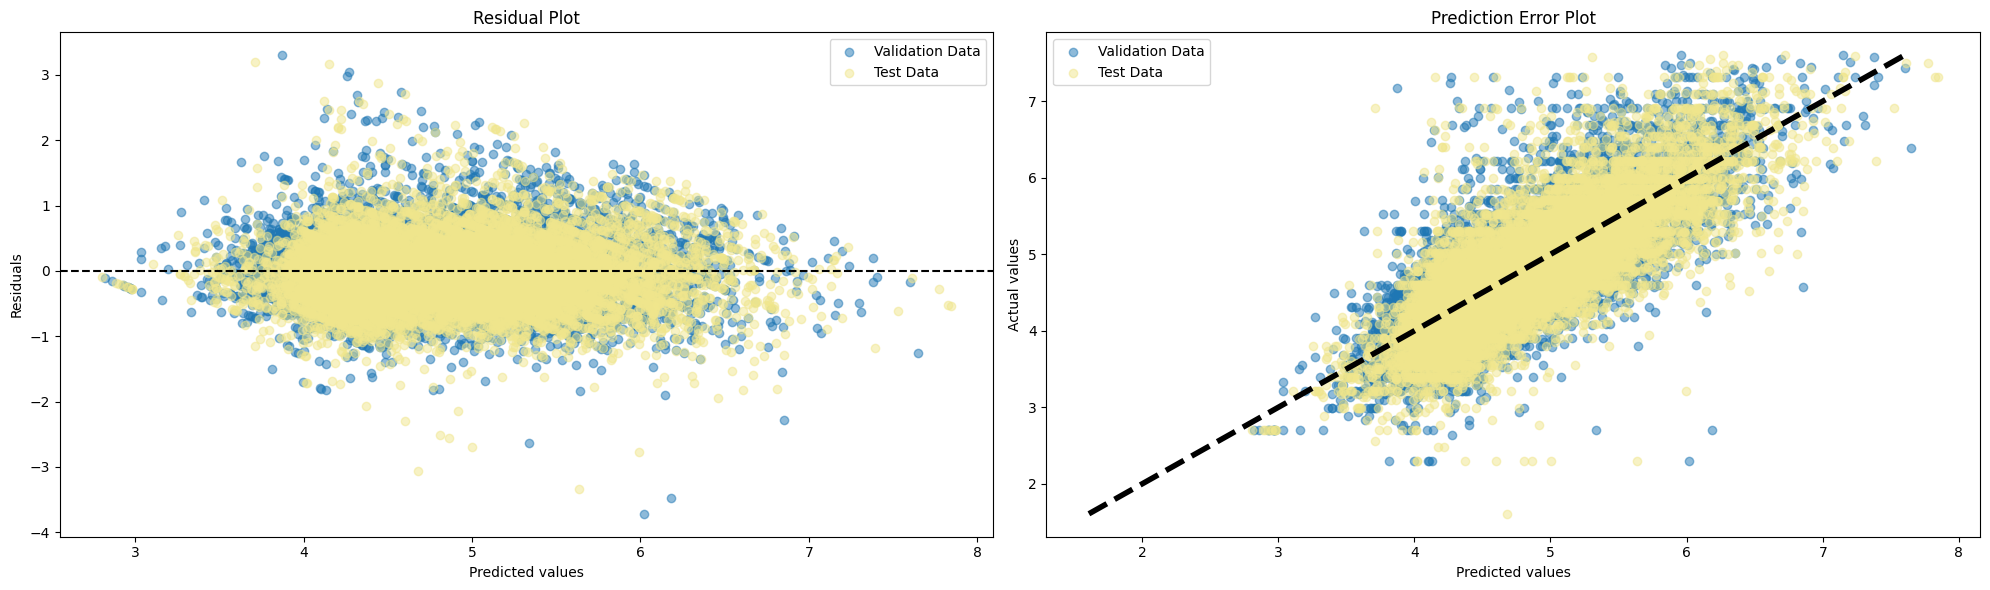

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

residuals_val = y_val - y_val_pred.flatten()  # Ensure y_val_pred is correctly shaped
residuals_test = y_test - y_pred.flatten()    # Ensure y_pred is correctly shaped


ax1.scatter(y_val_pred, residuals_val, alpha=0.5, label='Validation Data')
ax1.scatter(y_pred, residuals_test, alpha=0.5, color='Khaki', label='Test Data')
ax1.set_title('Residual Plot')
ax1.set_xlabel('Predicted values')
ax1.set_ylabel('Residuals')
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='--')


ax2.scatter(y_val_pred, y_val, alpha=0.5, label='Validation Data')
ax2.scatter(y_pred, y_test, alpha=0.5, color='Khaki', label='Test Data')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax2.set_title('Prediction Error Plot')
ax2.set_xlabel('Predicted values')
ax2.set_ylabel('Actual values')
ax2.legend()


plt.tight_layout()
plt.show()

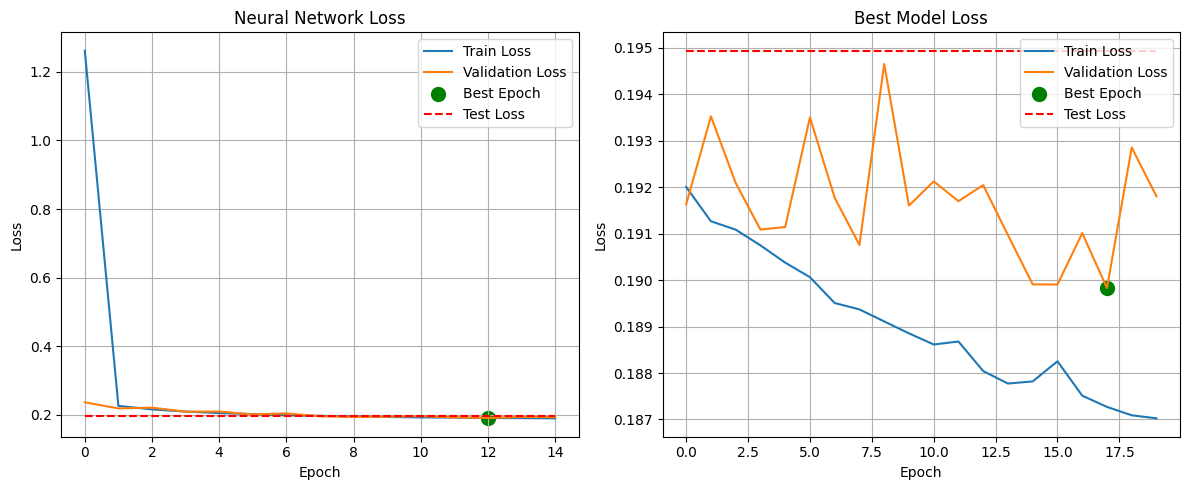

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_metrics(history_nn, mse_nn, modelName='Neural Network', ax = axs[0])
plot_metrics(history_best, test_loss_best, modelName = 'Best Model', ax = axs[1])
plt.tight_layout()
plt.show()

## XGboost

In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
}

xgb_model = xgb.XGBRegressor(n_estimators=250, random_state=42,objective='reg:squarederror', eval_metric='rmse',early_stopping_rounds=10)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=False, n_jobs=-1)

grid_search.fit(X_train_full, y_train_full, eval_set=[(X_val, y_val)], verbose=False)

# Retrieve the best model
best_model = grid_search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Best parameters found: ", grid_search.best_params_)
print("Train MSE: ", mse_train)
print("Test MSE: ", mse_test)

KeyboardInterrupt: 

In [ ]:
y_pred_train = bst.predict(X_train, num_iteration=bst.best_iteration)
y_pred_test = bst.predict(X_test, num_iteration=bst.best_iteration)

xgb_mse_train = mean_squared_error(y_train, y_pred_train)
xgb_rmse_train = np.sqrt(xgb_mse_train)
xgb_mae_train = mean_absolute_error(y_train, y_pred_train)
xgb_r2_train = r2_score(y_train, y_pred_train)

xgb_mse_test = mean_squared_error(y_test, y_pred_test)
xgb_rmse_test = np.sqrt(xgb_mse_test)
xgb_mae_test = mean_absolute_error(y_test, y_pred_test)
xgb_r2_test = r2_score(y_test, y_pred_test)

# Print out the metrics
print("Training Metrics:")
print(f"MAE: {xgb_mae_train}")
print(f"RMSE: {xgb_rmse_train}")
print(f"MSE: {xgb_rmse_train}")
print(f"R2 Score: {xgb_r2_train}")

print("\nTest Set Metrics:")
print(f"MAE: {xgb_mae_test}")
print(f"RMSE: {xgb_rmse_test}")
print(f"MSE: {xgb_mse_test}")
print(f"R2 Score: {xgb_r2_test}")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Calculating residuals for validation and test sets
residuals_val = y_val - y_val_pred
residuals_test = y_test - y_test_pred

# Residual plot on the first axis
ax1.scatter(y_val_pred, residuals_val, alpha=0.5, label='Validation Data')
ax1.scatter(y_test_pred, residuals_test, alpha=0.5, color='Khaki', label='Test Data')
ax1.set_title('Residual Plot')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Residuals')
ax1.legend()
ax1.axhline(y=0, color='black', linestyle='--')

# Prediction error plot on the second axis
ax2.scatter(y_val_pred, y_val, alpha=0.5, label='Validation Data')
ax2.scatter(y_test_pred, y_test, alpha=0.5, color='Khaki', label='Test Data')
# Ensure the range covers both validation and test data
all_data_range = [min(y_val.min(), y_test.min()), max(y_val.max(), y_test.max())]
ax2.plot(all_data_range, all_data_range, 'k--', lw=4)
ax2.set_title('Prediction Error Plot')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Actual Values')
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()